In [6]:
import numpy as np
import os, sys, glob, abc
%matplotlib inline
from matplotlib import pyplot as plt, colors
import mla.core
from mla.spectral import *
def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
data = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
sim = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
#data['angErr'][data['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
#sim['angErr'][sim['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

data['ra']=np.random.uniform(0,2*np.pi,size=len(data))

In [7]:
# from mla.spectral import *
# from mla import injection
# sp= PowerLaw(1,1e-15,2)
# dec = 22.0145*np.pi/180
# ra = 83.63*np.pi/180
# inj = injection.PSinjector(sp,sim)
# inj.set_source_location(ra,dec)
# sample=inj.sample_nevents(15)
# background = np.random.choice(data, 30).copy()
# background['time']=0.5
# import numpy.lib.recfunctions as rf
# sample = rf.drop_fields(sample, [n for n in sample.dtype.names \
#      if not n in background.dtype.names])
# injected = np.concatenate([background,sample])
# np.save("testdata.npy",injected)

In [50]:
from imp import reload
import scipy.optimize
reload(mla.core)

sp= PowerLaw(1000,1e-15,2)
testdata=np.load("test3.npy")
testdata['time']=0.5
import warnings
warnings.filterwarnings("ignore")
test=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , testdata , sim , "PowerLaw", background = data , \
                              )

In [52]:
test.get_fit_result()

(-2.6895095337468753, 77.93372640190165, 258.79452207181066)

In [53]:
gamma=np.linspace(-1.5,-3.5,30)
ns=np.linspace(70,120,50)
result=[]
for i in gamma:
    test.update_energy_weight(gamma=i)
    for j in ns:
        temp=test.eval_llh_ns(j)
        result.append([i,j,temp[0],temp[1]])

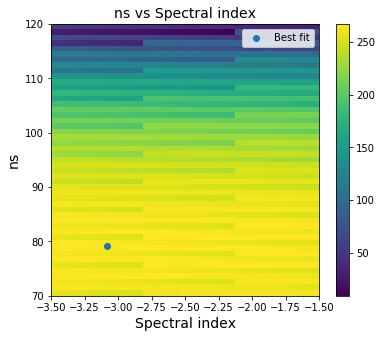

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
result=np.array(result)
x=result[:,0]
y=result[:,1]
z=result[:,3]

## Equivalently, we could do that all in one line with:
# x,y,z = np.genfromtxt('eye_.txt', delimiter=',', usecols=(0,1,2))
z[z<0]=0
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z=z.reshape(len(y),len(x))
index=result[np.argmax(result[:,3])]
fig, ax = plt.subplots(figsize = (6,5))
plt.pcolormesh(X,np.flip(Y),Z)
plt.colorbar()
plt.scatter(index[0],index[1],label="Best fit")
plt.title("ns vs Spectral index",fontsize=14)
plt.xlabel(r"Spectral index",fontsize=14)
plt.ylabel("ns",fontsize=14)
plt.legend()
plt.show()

In [23]:
ratio,bins=mla.core.create_interpolated_ratio(data,sim,gamma=-2)

In [32]:
ratio[68,:]

array([ 0.06834721,  0.06834721,  0.06834721,  0.06834721,  0.06834721,
        0.06834721,  0.06834721,  0.06834721,  0.09175646,  0.11516571,
        0.13857495,  0.33046875,  0.33504445,  0.45546043,  0.42545713,
        0.39545384,  0.36545054,  0.22987788,  0.22954305,  0.38466284,
        0.95551027,  0.4529306 ,  0.47995544,  0.47805385,  0.52651339,
        0.47107771,  0.44226963,  0.49554312,  0.55701129,  0.77454839,
        0.89894442,  1.17193596,  1.81531367,  2.69509971,  2.21822784,
        4.25270507,  6.33030198, 10.28319062, 16.46696607, 15.05100584,
       11.42466628,  8.18559532, 11.73961776, 15.45919242, 19.32838536,
       14.90131941, 10.47425346, 10.47425346, 10.47425346, 10.47425346,
       10.47425346, 10.47425346, 10.47425346, 10.47425346, 10.47425346,
       10.47425346, 10.47425346, 10.47425346, 10.47425346, 10.47425346,
       10.47425346, 10.47425346, 10.47425346, 10.47425346, 10.47425346,
       10.47425346, 10.47425346, 10.47425346, 10.47425346, 10.47